# Solving a Coupled System of Ordinary Differential Equations with Neural Networks

*Based on the paper [Artificial Neural Networks for Solving Ordinary and Partial Differential Equations by I. E. Lagaris, A. Likas and D. I. Fotiadis(1997)](https://arxiv.org/abs/physics/9705023)*

## Problem 03

**Problem:** Find solution of 
$$
  u_1'(x) = \cos(x) + u_1^2(x) + u_2(x)- (1+ x^2 + \sin(x))
  $$ $$ 
u_2'(x) = 2x -(1+x^2) \sin(x)+ u_1(x) u_2(x) $$


with initial values  $u_1(0) = 0$ and $u_2(0) = 1$ on the interval $[0,2]$


## Notation

$u_{N_1}, u_{N_2}$ denote the **trial solutions** containing a neural networks, that we will train in the following.

$u_{a_1}, u_{a_2}$ denotes the **analytic solution** or the *target functions* of the coupled ODE above. This is what our neural network should learn. The exact analytic solution of the coupled ODE above reads 

$$
    u_{a_1}(x) = \sin(x)
$$
$$ 
   u_{a_2}(x) = 1 + x^2
$$ 
## Key Idea

Write 

$$u_{N_1}(x) = x N_{p_1}(x),$$

$$u_{N_2}(x) = 1 + x N_{p_2}(x),$$

where $N_{p_1}, N_{p_2}$ are the neural networks with training parameters $p_1, p_2$. We can easily see that

$$
    u_{N_1}(0) = 0 \cdot N_{p_1}(0) = 0.
$$
$$
  u_{N_2} (0) = 1+ x \cdot N_{p_2}(0) = 1
$$ 

Thus, this approach satisfies the initial value condition. It just remains to adjust the parameter $p$ such that $u_{N_1}(x) = x N_{p_1}(x)$ and $u_{N_2}(x) = 1 + x N_{p_2}(x)$ approximate the target functions $u_{a_1}, u_{a_2}$ for any $x \in [0,2]$ very well.

## Architecture of the Neural Network

We use a neural network with **one hidden layer** containing **$H=10$ neurons** and the **sigmoid function** as the activation function. The neural network has one single input layer and a single linear output layer.

## Training the Neural Network

Discretize $[0,2]$ such that we have a grid of $10$ equidistant points $x_1,...,x_{10} \in [0,2]$. Define the **loss function** as

$$
    E = \sum_{i=1}^{10} \left(u_{N_1}'(x_i) - f_1(x_i, u_{N_1}(x_i), u_{N_2}(x_i))\right)^2+ \sum_{i=1}^{10} \left(u_{N_2}'(x_i) - f_1(x_i, u_{N_1}(x_i), u_{N_2}(x_i))\right)^2,
$$

where $f$ is the right hand side of the ODE.

In [0]:
%matplotlib inline
%tensorflow_version 1.x 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

In [0]:
# domain of the solution
DOMAIN = [0.0, 2.0]

# number of neurons in the hidden layer
WIDTH = 10 

# number of discretization points/ number of training points
NUM_TRAINING_POINTS = 10

# number of neurons in the input layer
INPUT_DIMENSION = 1

# grid of equidistant points in the DOMAIN
TRAINING_POINTS = xs = np.linspace(DOMAIN[0], DOMAIN[1], NUM_TRAINING_POINTS)

# both target functions 
def target_func1(x):
    return np.sin(x)

def target_func2(x): 
    return 1+ x**2

Next, we construct our shallow neural networks .

In [0]:
initializer = tf.contrib.layers.xavier_initializer()
#------- Neural network N_1 -------------------------
# Input layer
input = tf.placeholder(dtype=tf.float32, shape=(None, INPUT_DIMENSION, ), name="input")
batch_size = tf.shape(input)[0]
# ----Hidden layer----
# Weights first hidden layer
W1 = tf.Variable(initializer((WIDTH, INPUT_DIMENSION)), dtype=tf.float32, name="W1") 
# Bias
b1 = tf.Variable(initializer((WIDTH,)), dtype=tf.float32, name="b1") 

z1 = tf.matmul(tf.broadcast_to(W1, [batch_size,WIDTH,INPUT_DIMENSION] ), tf.reshape(input, shape=[-1, INPUT_DIMENSION, 1]))
z1 = z1 + tf.reshape(b1, shape=(WIDTH, 1))
# values at hidden layer 
sigmoid_z1 = tf.nn.sigmoid(z1)
#---- output unit --------
# Single Output layer
v1 = tf.Variable(initializer((1,WIDTH)), dtype=tf.float32, name="v1") 
# Weights output layer
output1 = tf.reshape(tf.matmul(tf.broadcast_to(v1,[batch_size,1,WIDTH]), sigmoid_z1), [-1,1,])

#------- Neural network N_2 -------------------------
# Use the same input layer as for N_1
# Hidden layer
# Weights first hidden layer
W2 = tf.Variable(initializer((WIDTH, INPUT_DIMENSION)), dtype=tf.float32, name="W2") 
# Bias
b2 = tf.Variable(initializer((WIDTH,)), dtype=tf.float32, name="b2") 

z2 = tf.matmul(tf.broadcast_to(W2, [batch_size,WIDTH,INPUT_DIMENSION] ), tf.reshape(input, shape=[-1, INPUT_DIMENSION, 1]))
z2 = z2 + tf.reshape(b2, shape=(WIDTH, 1))
# value at hidden layer 
sigmoid_z2 = tf.nn.sigmoid(z2)
#----- output unit -------
# Single Output layer
v2 = tf.Variable(initializer((1,WIDTH)), dtype=tf.float32, name="v2") 
# Weights output layer
output2 = tf.reshape(tf.matmul(tf.broadcast_to(v2,[batch_size,1,WIDTH]), sigmoid_z2), [-1,1,])


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Now we will compute the derivatives of our trial solutions
$$u_{N_1}'(x) = x N_{N_1}'(x) + N_{N_1}(x) $$ 
$$u_{N_2}'(x) = x N_{N_2}'(x) + N_{N_2}(x) $$ 

In [0]:
#------ trial solutions ------------------
u1 =  input * output1
u2 = 1+ input * output2 

#------- first derivative of u_1 ------------
vW1 = tf.multiply(tf.reshape(W1, [WIDTH]), v1)
sigmd1 = tf.multiply(tf.sigmoid(z1), (1-tf.sigmoid(z1)))
prod1 = tf.multiply(tf.reshape(vW1, shape = (1, -1, 1)), sigmd1)
dN1 = tf.reduce_sum(prod1, axis = 1) # first derivative of N_1
du1 = input * dN1 + output1

#------- first derivative of u_2 ------------
vW2 = tf.multiply(tf.reshape(W2, [WIDTH]), v2)
sigmd2 = tf.multiply(tf.sigmoid(z2), (1-tf.sigmoid(z2)))
prod2 = tf.multiply(tf.reshape(vW2, shape = (1, -1, 1)), sigmd2)
dN2 = tf.reduce_sum(prod2, axis = 1) # first derivative of N_2
du2 = input * dN2 + output2

#------ loss function------------------------
f1 = tf.cos(input ) + u1*u1 + u2- 1 - input * input - tf.square(tf.sin(input))
f2 = 2* input - (1 + input * input )* tf.sin(input )+ u1 * u2

loss = tf.reduce_sum(tf.square(du1- f1) )+ tf.reduce_sum(tf.square(du2 - f2))

Training

Time elapsed: 53.711
Loss value: 0.00000609


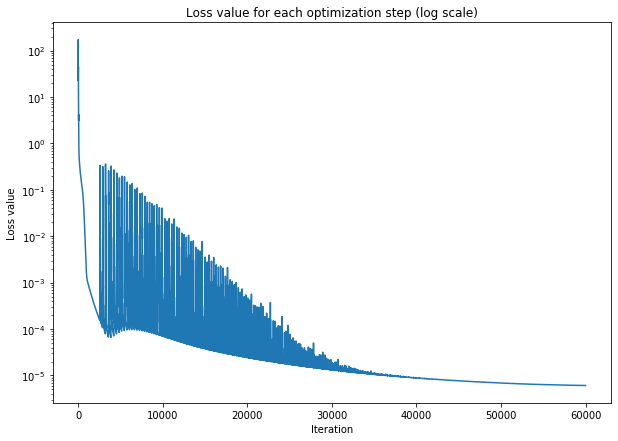

In [0]:
# Training parameters
#@markdown Number of training iterations
NUM_ITER = 60000 #@param {type:"integer"}
#@markdown Initial learning rate
INIT_L_RATE = 0.1 #@param {type:"number"}
#@markdown Final learning rate
FINAL_L_RATE = 1e-6 #@param {type:"number"}


global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(
    INIT_L_RATE,
    global_step,
    1,
    np.exp(np.log(FINAL_L_RATE/INIT_L_RATE) / NUM_ITER),
    staircase=True
)

# Optimizer
step = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

session = tf.Session()
session.run(tf.global_variables_initializer())

ERROR_RATE = []

t0 = time.time()
# Training
for i in range(NUM_ITER):
    loss_val, _  = session.run(
        [loss, step],
        feed_dict={ input: np.reshape(np.array(xs), (-1,1)) }    
    )
    ERROR_RATE.append(loss_val)

# Plotting
plt.figure(figsize = (10,7))
plt.title("Loss value for each optimization step (log scale)")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.plot(ERROR_RATE)

print("Time elapsed: {:0.3f}".format(time.time() - t0))
print("Loss value: {:0.8f}".format(ERROR_RATE[-1]))

Compare the trial solution of the neural network with the target function.

Text(0.5, 1.0, 'Approximation error of $u_{N_1}$ and $u_{N_2}$')

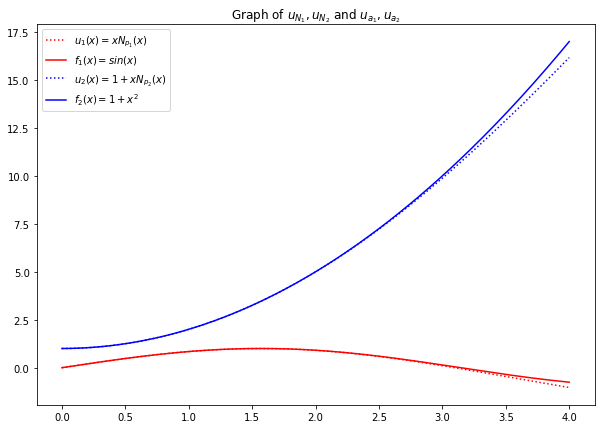

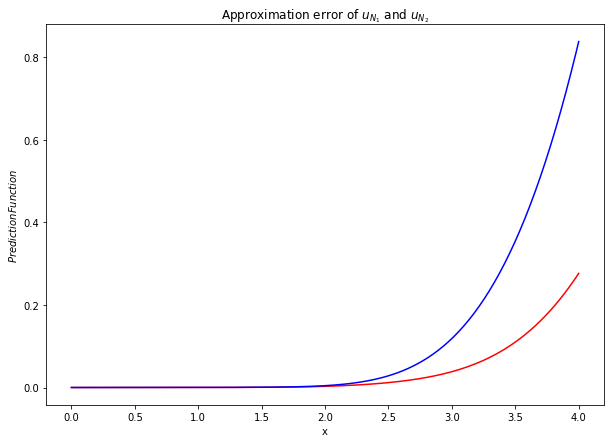

In [0]:
#@markdown Plots the functions from X_START to X_END
X_START = 0 #@param {type:"number"}
X_END =  4#@param {type:"number"}
RESOLUTION = 200
xaxis = np.linspace(X_START,X_END,RESOLUTION)

target1 = target_func1(xaxis)
target2 = target_func2(xaxis)
prediction1 = np.reshape(session.run(u1,
                        feed_dict={input: np.reshape(xaxis,(-1,1))}
                        ), (-1,)) 

prediction2 = np.reshape(session.run(u2,
                        feed_dict={input: np.reshape(xaxis,(-1,1))}
                        ), (-1,))

plt.figure(0, figsize=(10,7))

plt.plot(xaxis, prediction1, label="$u_1(x) = x N_{p_1}(x)$", color='r', linestyle=':')
plt.plot(xaxis, target1, label="$f_1(x) = sin(x)$", color='r')
plt.plot(xaxis, prediction2, label="$u_2(x) = 1 +x N_{p_2}(x) $", color='b', linestyle=':')
plt.plot(xaxis, target2, label="$f_2(x) = 1+ x^2$", color='b')

plt.title("Graph of $u_{N_1}, u_{N_2}$ and $u_{a_1}, u_{a_2}$")
plt.legend(loc=0)


plt.figure(1, figsize=(10,7))
plt.plot(xaxis, np.absolute(prediction1-target1), label = 'Error u_{N_1}',color = 'r')
plt.plot(xaxis, np.absolute(prediction2-target2), label = 'Error u_{N_2}',color = 'b')
plt.xlabel("x")
plt.ylabel("$Prediction Function $")
plt.title("Approximation error of $u_{N_1}$ and $u_{N_2}$")

Length of History: 61
